# Pharmaceutical Retail: Sales Insights and Trends
## Dataset
In this analysis, we will explore the [pharmaceutical-retails-sales-2015 dataset](https://www.kaggle.com/datasets/tigernaing/pharmaceutical-retails-sales-2015#) available on [Kaggle](https://www.kaggle.com/datasets) to gain insights into pharmaceutical sales trends throughout the year.  

We will focus on:
* **Monthly Sales Patterns**: Analyzing sales fluctuations across months
* **Product Sales Distribution**: Exploring how sales are distributed among different products
* **High-Frequency Sales Products**: Identifying top-selling products based on frequency.
* **Low-Frequency Sales Products**: Highlighting items with the lowest sales activity

Run this notebook on [mybinder.org](https://mybinder.org/v2/gh/T-Naing/Jupyter/main?urlpath=%2Fdoc%2Ftree%2FEDA_pharma_retails_2015%2FEDA_pharma_sales_analysis.ipynb).
>
>https://mybinder.org/v2/gh/T-Naing/Jupyter/main?urlpath=%2Fdoc%2Ftree%2FEDA_pharma_retails_2015%2FEDA_pharma_sales_analysis.ipynb

We will install the necessary packages: pandas, matplotlib, and seaborn.

In [72]:
# !pip install -q -r requirements.txt

### Download Dataset
Since downloading from Kaggle requires user credentials, I've provided a copy of the dataset on GitHub for convenience. Let's download it from there instead.

In [73]:
url = "https://media.githubusercontent.com/media/T-Naing/Jupyter/refs/heads/main/EDA_pharma_retails_2015/pharma_sales_product_2015.csv"

In [74]:
import urllib.request
urllib.request.urlretrieve(url,"./pharma_sales_product_2015.csv" )

('./pharma_sales_product_2015.csv', <http.client.HTTPMessage at 0x246f011a330>)

I've already downloaded the dataset from GitHub, so we'll verify if 'pharma_sales_product_2015.csv' is available in the current folder.

In [75]:
import os 

In [76]:
path=os.getcwd()

In [77]:
os.listdir(path)

['.ipynb_checkpoints',
 '.jupyter',
 'EDA_pharma_sales_analysis.ipynb',
 'pharma_sales_product_2015.csv',
 'requirements.txt']

The dataset is ready, so we'll move forward.

### Import the Dataset
We will import the **pharma_sales_product_2015.csv** file into a pandas DataFrame.

In [78]:
import pandas as pd

In [79]:
pharma_df=pd.read_csv('./pharma_sales_product_2015.csv')

In [80]:
pharma_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22800 entries, 0 to 22799
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InvoiceNo     22800 non-null  int64 
 1   InvoiceDate   22800 non-null  object
 2   ProductNo     22800 non-null  int64 
 3   Quantity      22800 non-null  int64 
 4   Unit          22800 non-null  object
 5   ProductName   22800 non-null  object
 6   PackSize      22800 non-null  object
 7   ChemicalName  22800 non-null  object
dtypes: int64(3), object(5)
memory usage: 1.4+ MB


In [81]:
# pharma_df.describe()

In [82]:
# pharma_df.sample(5)

In [83]:
# pharma_df.head()

In [84]:
# pharma_df.tail()

In [85]:
# len(pharma_df.ProductNo.value_counts())

In [86]:
# pharma_df.ProductNo.value_counts()

In [87]:
pharma_df.ProductNo.nunique()

873

### Overview of the Dataset
>The dataset comprises 8 columns and contains information about product sales, including InvoiceNo, InvoiceDate, Quantity, and other product details. It consists of `22,800` records.
>
>The dataset contains sales data from January 1, 2015, to December 31, 2015. A total of `873` products were sold during this period.

## Data Preparation
In our dataset, some items contain '?' symbols, which are originally Burmese characters. These characters were replaced with '?' during the SQL-to-CSV export process. Since the affected product names are unidentifiable, we will remove them from the dataset before proceeding with the analysis.
### Removing Unidentifiable Products

In [88]:
pharma_df[pharma_df["ProductName"].
    str.contains(r"\?", regex=True)].shape

(2158, 8)

We identified 2,158 records where the product name contains '?'. These records will be removed from the DataFrame to ensure data accuracy before proceeding with the analysis.

In [89]:
pharma_df = pharma_df[~pharma_df["ProductName"].
    str.contains(r"\?", regex=True)]

In [90]:
pharma_df.shape

(20642, 8)

### DateTime Conversion
The dataset contains an 'InvoiceDate' column, currently stored as an object data type. To extract meaningful insights, we must convert it into a DateTime format.

In [91]:
pharma_df['InvoiceDate']=pd.DatetimeIndex(pharma_df.InvoiceDate)

In [92]:
pharma_df.at[22799, "InvoiceDate"].year

2015

In [93]:
# pharma_df.head()

Now that the InvoiceDate column is in the correct DateTime format. 

Since we may examine monthly sales trends, we'll add Day, Month, and MonthName columns derived from InvoiceDate.

In [94]:
pharma_df['Month']=pd.DatetimeIndex(pharma_df.InvoiceDate).month
pharma_df['MonthName']=pd.DatetimeIndex(pharma_df.InvoiceDate).month_name()
pharma_df['Day']=pd.DatetimeIndex(pharma_df.InvoiceDate).day
# pharma_df['WeekDay']=pd.DatetimeIndex(pharma_df.InvoiceDate).weekday
# pharma_df['DayName']=pd.DatetimeIndex(pharma_df.InvoiceDate).day_name()

In our dataset, products were sold in various unit types. By utilizing pack size information (e.g., `20 tabs * 5 strips * box`), we will standardize the '*Quantity*' and '*Unit*' into **the most commonly used sales unit** and calculate the corresponding quantities (e.g., `50` `stp`) for each product before analyzing the data.
### Converting Product Sales to the Most Frequent Unit
To accomplish this, we will first develop a unit conversion algorithm. Next, we will identify the most commonly used sales unit for each product and standardize all sales records accordingly.

#### 1. Unit Conversion Algorithm
The `conversion_table` function retrieves the conversion factors for each unit based on the pack size and returns the conversion table as a list.

In [95]:
def conversion_table(pack):
    conversions=pack.split('*')
    conversions[-1]='1 '+conversions[-1].strip()
    conversion_table=[]
    
    for conversion in conversions:
        q,u=conversion.strip().split()
        conversion_table.append((int(q),u))
    
    return conversion_table

The `get_index` function retrieves the index of the source unit and target unit from the conversion table to obtain the respective conversion factors.

In [96]:
def get_index(conversion_table,from_unit,to_unit):
    from_i=to_i=-1
    for i, item in enumerate(conversion_table):
        if item[1]==from_unit:
            from_i=i
        elif item[1]==to_unit:
            to_i=i
    return from_i, to_i

The following `convert` function takes the source quantity, source unit, target unit, and pack size, performs unit conversion, and returns the target quantity and unit as a tuple. 

In [97]:
def convert(qty,from_unit,to_unit,pack):
    table=conversion_table(pack)
    from_index, to_index = get_index(table,from_unit,to_unit)
    
    if from_index !=-1 and to_index!=-1 :        
        if from_index>to_index:
            # print('big to small')
            for j in table[to_index:from_index]:
                qty=qty*j[0]
            return_unit=table[to_index][1] 
        elif from_index<to_index:
            # print('small to big')
            for j in table[from_index:to_index]:
                qty=qty/j[0]       
            return_unit=table[to_index][1]
    else:
        return_unit=from_unit            
    return qty,return_unit

In [98]:
conversion_table(pack = '20 tab * 5 stp * box')

[(20, 'tab'), (5, 'stp'), (1, 'box')]

In [99]:
get_index (conversion_table('20 tab * 5 stp * box'), from_unit = 'box', to_unit = 'tab')

(2, 0)

In [100]:
convert(qty = 50, from_unit = 'box', to_unit= 'tab', 
        pack = '20 tab * 5 stp * box')

(5000, 'tab')

In [101]:
convert(50,'tab', 'box','20 tab * 5 stp * box')

(0.5, 'box')

In [102]:
conversion_table('20 tab * 5 stp * box')[-1][-1]

'box'

#### 2. Determine the Most Common Sales Unit
To determine the most common sales unit, we will first count the number of invoices, grouping them by each product unit. Then, we will evaluate the most frequently sold unit for each product based on invoice count and store the result in a new column.

In [103]:
# Group by ProductNo and Unit, and aggregate data
agg_temp_df = pharma_df.groupby(['ProductNo', 'Unit']).agg({
    'ProductName': 'first',
    'InvoiceNo': 'count'
}).reset_index()
agg_temp_df.rename(columns={'InvoiceNo':'InvoiceCount'},inplace=True)
# agg_temp_df

In [104]:
agg_temp_df.head()

ProductNo Unit ProductName  InvoiceCount
0          1  box         EVE             1
1          1  stp         EVE            40
2          2  box     Royal D             1
3          2  sac     Royal D           119
4          3  box     Eposoft             9

Since `agg_temp_df` holds the invoice count for each product unit, we will now evaluate the most common sales unit, store the results in a new DataFrame, and then merge it with `pharma_df` for further analysis.

In [105]:
# get the index of the most frequent sales unit 
idx = agg_temp_df.groupby(['ProductNo'])['InvoiceCount'].idxmax()

In [106]:
frequent_units_df = agg_temp_df.loc[idx, ['ProductNo', 'ProductName', 'Unit']].rename(columns={'Unit': 'FrequentUnit'})

In [107]:
 # agg_temp_df.loc[idx, ['ProductNo', 'ProductName', 'Unit']].rename(columns={'Unit': 'FrequentUnit'})# frequent_units_df

In [108]:
pharma_df=pharma_df.merge(frequent_units_df,on=['ProductNo', 'ProductName'])

In [109]:
(pharma_df[pharma_df["Unit"]!=pharma_df["FrequentUnit"]]).shape

(1435, 12)

As you can see there are 1435 records to make unit conversion.

Finally, we will convert all sales into the most common sales unit. 
#### 3. Apply the Standardized Unit

In [110]:
def apply_conversion(row):
    if row['Unit'] != row['FrequentUnit']:
        row['Quantity'], row['Unit'] = convert(row['Quantity'], row['Unit'], row['FrequentUnit'], row['PackSize'])
    return row

In [111]:
pharma_df = pharma_df.apply(apply_conversion, axis=1)

In [112]:
sum(pharma_df['Unit']!=pharma_df['FrequentUnit'])

0

In [113]:
# df.drop(columns='FrequentUnit',inplace=True)

In [114]:
# pharma_df.head(5)s

In [115]:
# pharma_df.info()

## Exploratory Analaysis
Now that we have cleaned the dataset, it is ready for exploration.

In [116]:
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['font.size']=14
plt.rcParams['figure.figsize']=[12,6]

### Monthly Trends in Daily Transaction Volume
We’ll explore daily transaction volumes across each month to identify recurring patterns or sales cycles.

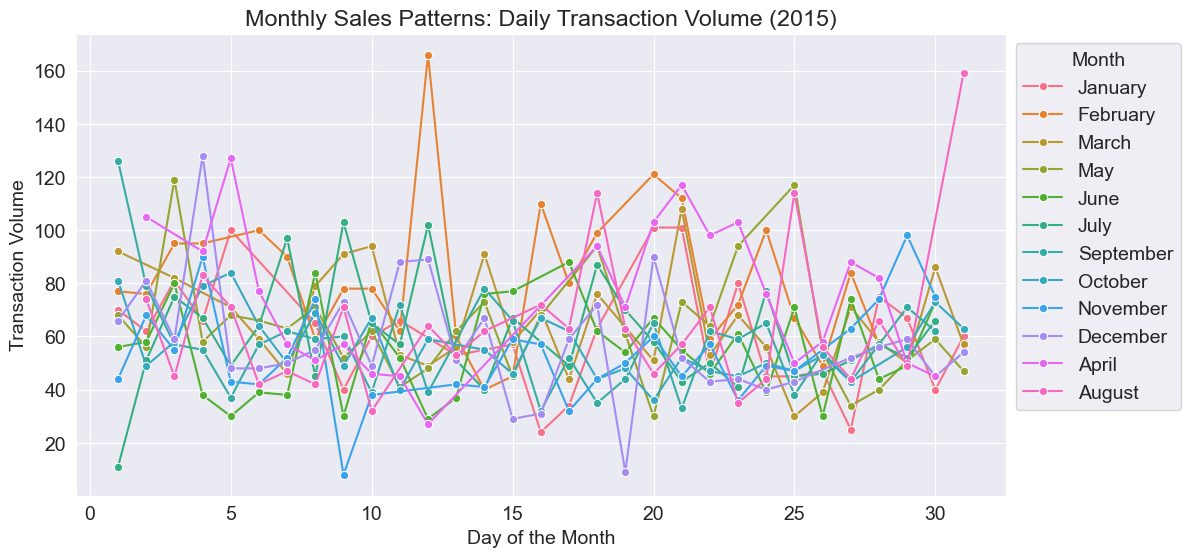

In [117]:
dtv_df = (pharma_df.groupby(["Day","Month","MonthName"])
    .agg({"Quantity": "sum", "InvoiceNo": "count"})
    .reset_index())

dtv_df = dtv_df.rename(columns={"InvoiceNo": "InvoiceCount"})

# plt.figure(figsize=(12, 6))
sns.lineplot(data=dtv_df, x="Day", y="InvoiceCount", hue="MonthName", marker="o")

plt.xlabel("Day of the Month")
plt.ylabel("Transaction Volume")
plt.title("Monthly Sales Patterns: Daily Transaction Volume (2015)")
plt.legend(title="Month",bbox_to_anchor=(1, 1))

plt.show()

> Since the lines do not align consistently month by month, there appears to be no clear monthly trend.

### Average Daily Transactions: Monthly Patterns

In [118]:
mthly_sls_df = (pharma_df.groupby(["Month","MonthName"])
    .agg({"Day": "nunique", "InvoiceNo": "count", "Quantity":"sum"})
    .reset_index())

mthly_sls_df = (mthly_sls_df
    .rename(columns={"InvoiceNo": "InvoiceCount"}))

mthly_sls_df["AvgDlyTnx"] = (mthly_sls_df["InvoiceCount"] / mthly_sls_df["Day"])
mthly_sls_df["AvgDlySls"] = mthly_sls_df["Quantity"] / mthly_sls_df["Day"]
mthly_sls_df["AvgSlsVolPerTnx"] = mthly_sls_df["AvgDlySls"] / mthly_sls_df["AvgDlyTnx"]

# mthly_sls_df

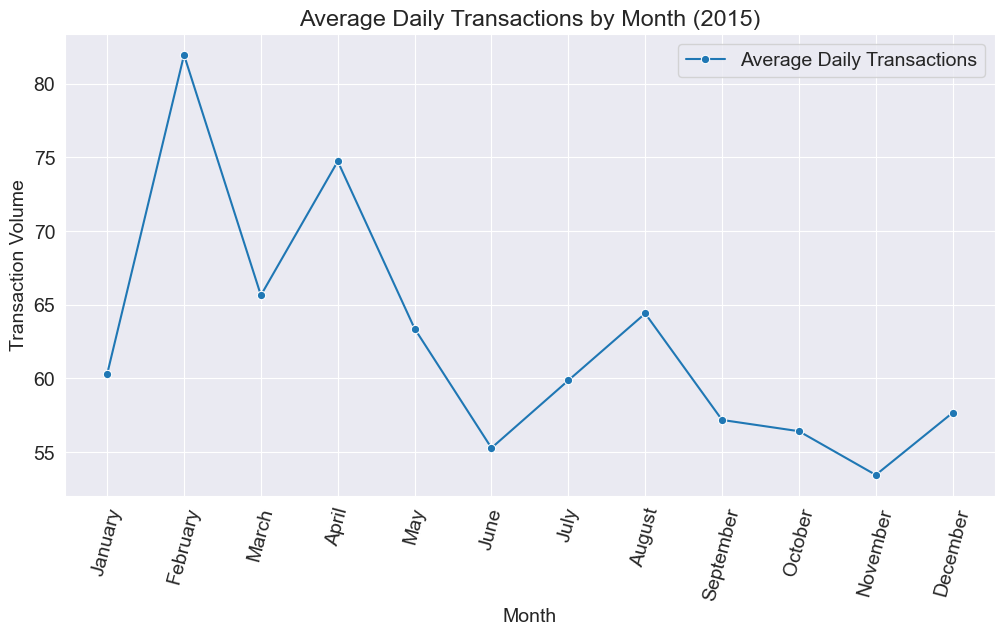

In [119]:
sns.lineplot(data = mthly_sls_df, x="MonthName", y="AvgDlyTnx",marker="o")
plt.xticks(rotation=75)
plt.xlabel("Month")
plt.ylabel("Transaction Volume")
plt.title("Average Daily Transactions by Month (2015)")
plt.legend(["Average Daily Transactions"])
plt.grid(True)

plt.show()

> - The graph indicates that February had the highest average daily transaction volume, while November had the lowest.
> - Overall, average daily sales appear to be on a downward trend.

### Total Monthly Sales Transaction Volume

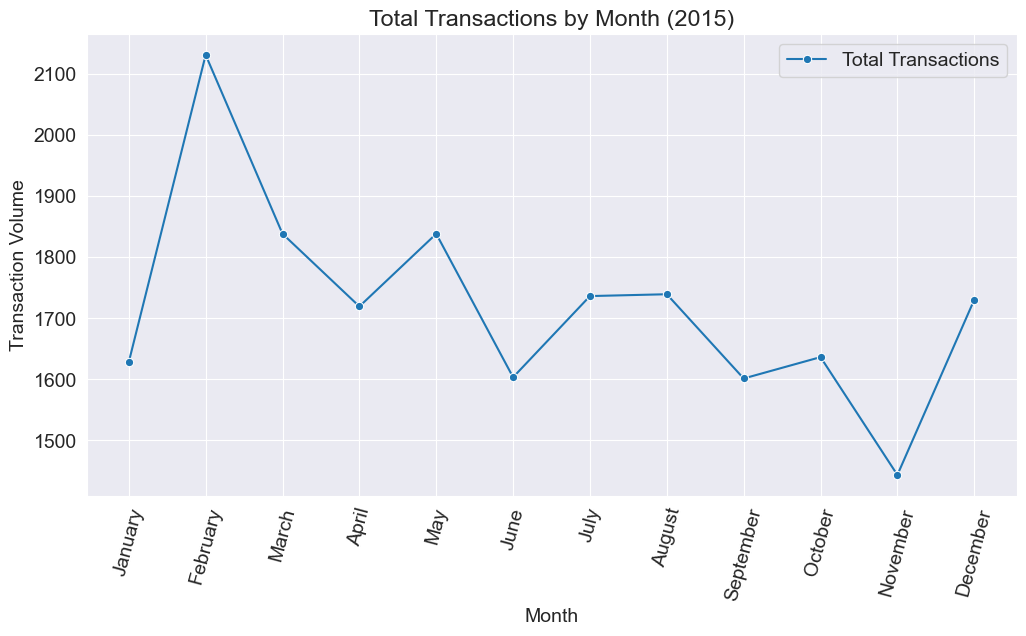

In [120]:
sns.lineplot(data = mthly_sls_df, x="MonthName", y="InvoiceCount",marker="o")
plt.xticks(rotation=75)
plt.xlabel("Month")
plt.ylabel("Transaction Volume")
plt.title("Total Transactions by Month (2015)")
plt.legend(["Total Transactions"])
plt.grid(True)

plt.show()

>- In 2015, February recorded the highest and November the lowest total transaction volumes—matching the peak and trough observed in average daily transactions.
>- Overall, sales transactions appear to be declining throughout the year.

### Comparison of Monthly Sales Volume and Daily Averages
To present monthly sales volume alongside the daily average per month we will use a dual-axis layout.

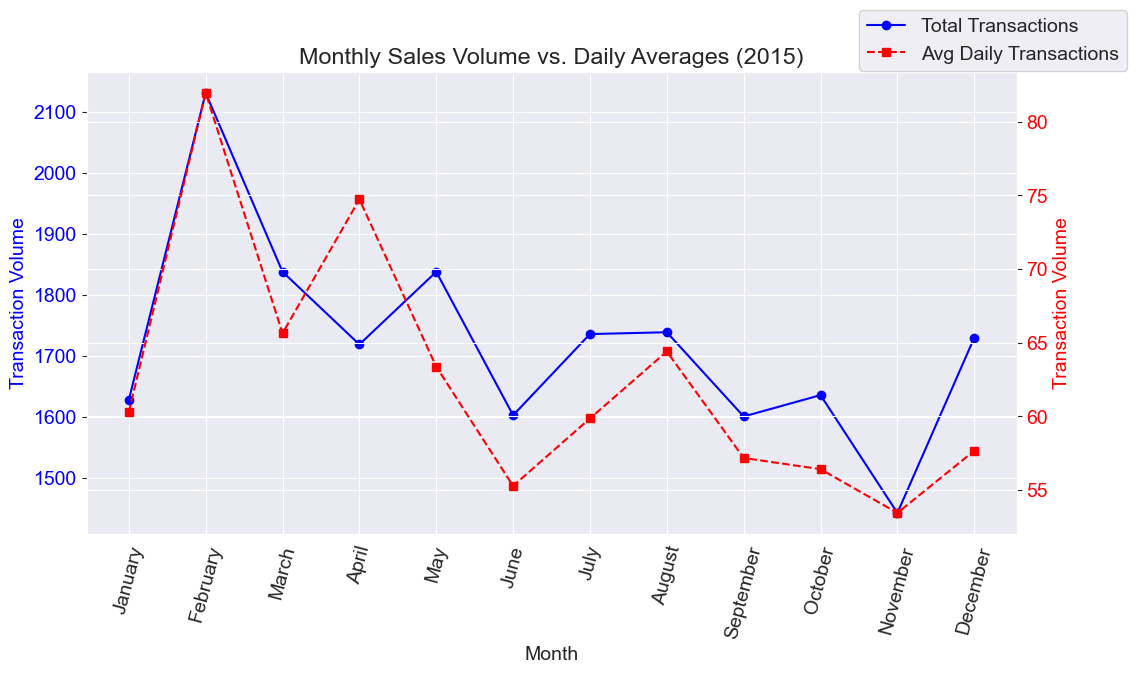

In [121]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot InvoiceCount on primary y-axis
ax1.plot(mthly_sls_df.MonthName, mthly_sls_df.InvoiceCount, label="Total Transactions", linestyle="-", marker="o", color="blue")
ax1.set_xlabel("Month")
ax1.set_ylabel("Transaction Volume", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.tick_params(axis="x", labelrotation=75)

# Create secondary y-axis
ax2 = ax1.twinx()
ax2.plot(mthly_sls_df.MonthName, mthly_sls_df.AvgDlyTnx, label="Avg Daily Transactions", linestyle="--", marker="s", color="red")
ax2.set_ylabel("Transaction Volume", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.tick_params(axis="x", labelrotation=75)

# Improve visualization
plt.title("Monthly Sales Volume vs. Daily Averages (2015)")
plt.xticks(rotation=45)
fig.legend(loc="upper right",bbox_to_anchor=(1 ,1))

plt.show()

> - In April, although the total number of transactions declined, the average daily transactions increased.
> - This might be due to the Thingyan Festival, which resulted in fewer business days—making the shop noticeably busier on the days it was open.

### Trend Analysis: Daily Transactions and Sales Quantity
Now, let’s explore customer purchasing behavior.

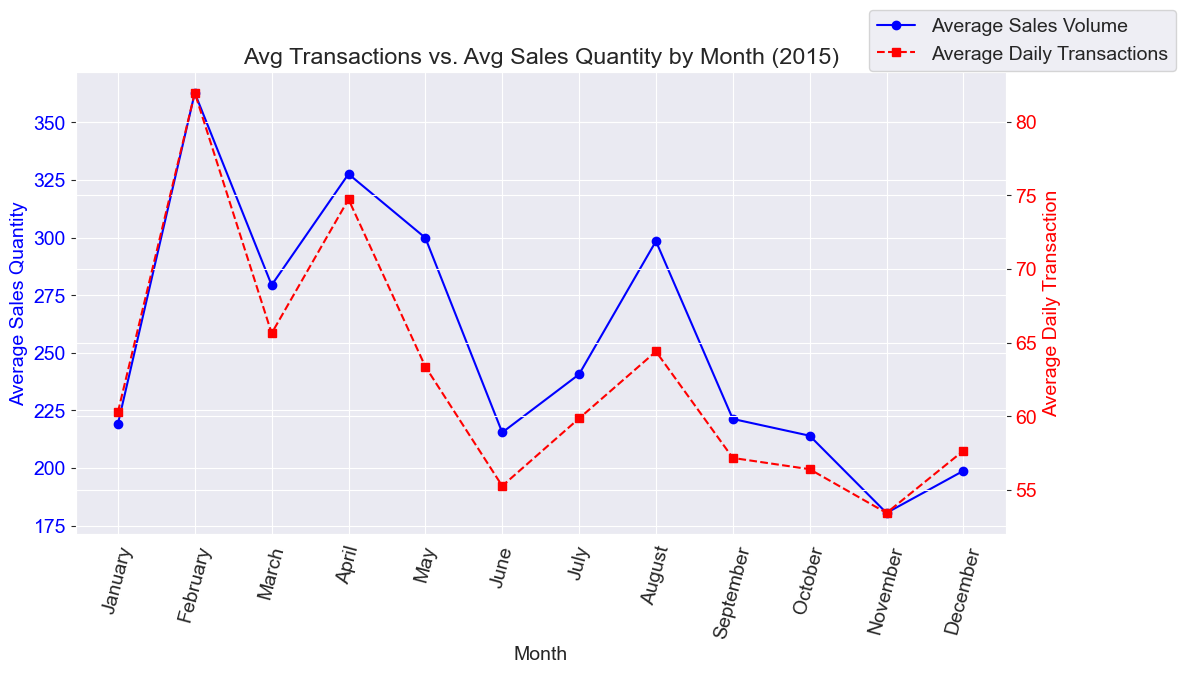

In [122]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot InvoiceCount on primary y-axis
ax1.plot(mthly_sls_df.MonthName, mthly_sls_df.AvgDlySls, label="Average Sales Volume", linestyle="-", marker="o", color="blue")
ax1.set_xlabel("Month")
ax1.set_ylabel("Average Sales Quantity", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.tick_params(axis="x", labelrotation=75)

# Create secondary y-axis
ax2 = ax1.twinx()
ax2.plot(mthly_sls_df.MonthName, mthly_sls_df.AvgDlyTnx, label="Average Daily Transactions", linestyle="--", marker="s", color="red")
ax2.set_ylabel("Average Daily Transaction", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.tick_params(axis="x", labelrotation=75)

# Improve visualization
plt.title("Avg Transactions vs. Avg Sales Quantity by Month (2015)")
plt.xticks(rotation=45)
fig.legend(loc="upper right",bbox_to_anchor=(1.05 ,1))

plt.show()

>Average daily transactions and sales volume moved up and down together each month, suggesting that purchase size remained relatively stable over time.

### Product Sales Distribution
We will examine the distribution of sales by product.

In [123]:
agg_explore_df=pharma_df.groupby(['ProductNo', 'Unit']).agg({
    'ProductName': 'first',
    'InvoiceNo': 'count'
}).reset_index()
agg_explore_df.rename(columns={'InvoiceNo':'InvoiceCount'},inplace=True)
# agg_explore_df

In [124]:
# Rearrange the columns order
# agg_explore_df=agg_explore_df[['ProductNo','ProductName','Unit','InvoiceCount']]
# agg_explore_df.sort_values('InvoiceCount',ascending=False,inplace=True)

Median: 12.0
Q1: 5.0
Q3: 32.5
Lower Whisker: 1
Upper Whisker: 73.75


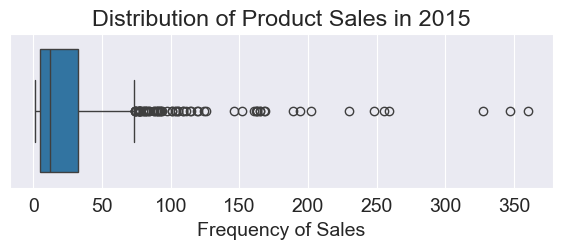

In [125]:
import numpy as np

invoice_counts = agg_explore_df['InvoiceCount']
median = np.median(invoice_counts) 
q1 = np.percentile(invoice_counts, 25) #Q1 is the median of the first half of the data
q3 = np.percentile(invoice_counts, 75)
iqr = q3 - q1
lower_whisker = max(min(invoice_counts), q1 - 1.5 * iqr)
upper_whisker = min(max(invoice_counts), q3 + 1.5 * iqr)

print("Median:", median)
print("Q1:", q1)
print("Q3:", q3)
print("Lower Whisker:", lower_whisker)
print("Upper Whisker:", upper_whisker)

plt.figure(figsize=(7,2))
sns.boxplot(data = agg_explore_df,x = agg_explore_df.InvoiceCount)
plt.title('Distribution of Product Sales in 2015')
plt.xlabel('Frequency of Sales');


>- Median (12.0): This represents the middle value of your sales volume, meaning half of the transactions are below 12 and half are above.
>- Q1 (5.0): The first quartile (Q1) indicates that 25% of your sales transactions are at or below 5.
>- Q3 (32.5): The third quartile (Q3) shows that 75% of your sales transactions are at or below 32.5.
>- Lower Whisker (1): The smallest non-outlier sales volume recorded.
>- Upper Whisker (73.75): The highest non-outlier sales volume recorded.

The outliers in the box plot indicate products with significantly higher sales. These products outperform others and can be considered high-performing in terms of sales frequency.

#### Identifying High-Performing Products from Outlier Sales

In [126]:
high_performing_df = agg_explore_df[agg_explore_df['InvoiceCount'] >upper_whisker].reset_index()
# high_performing_products = high_performing_df["ProductName"].unique()

In [127]:
high_performing_df.shape

(67, 5)

>There are 67 high-performing products with significantly higher sales compared to the rest of the dataset.<br>
>These products should be well-stocked.

#### 67 High-Performing Products
We will visualize the top 67 high-performing products in their most frequent sales units along with their respective sales figures.

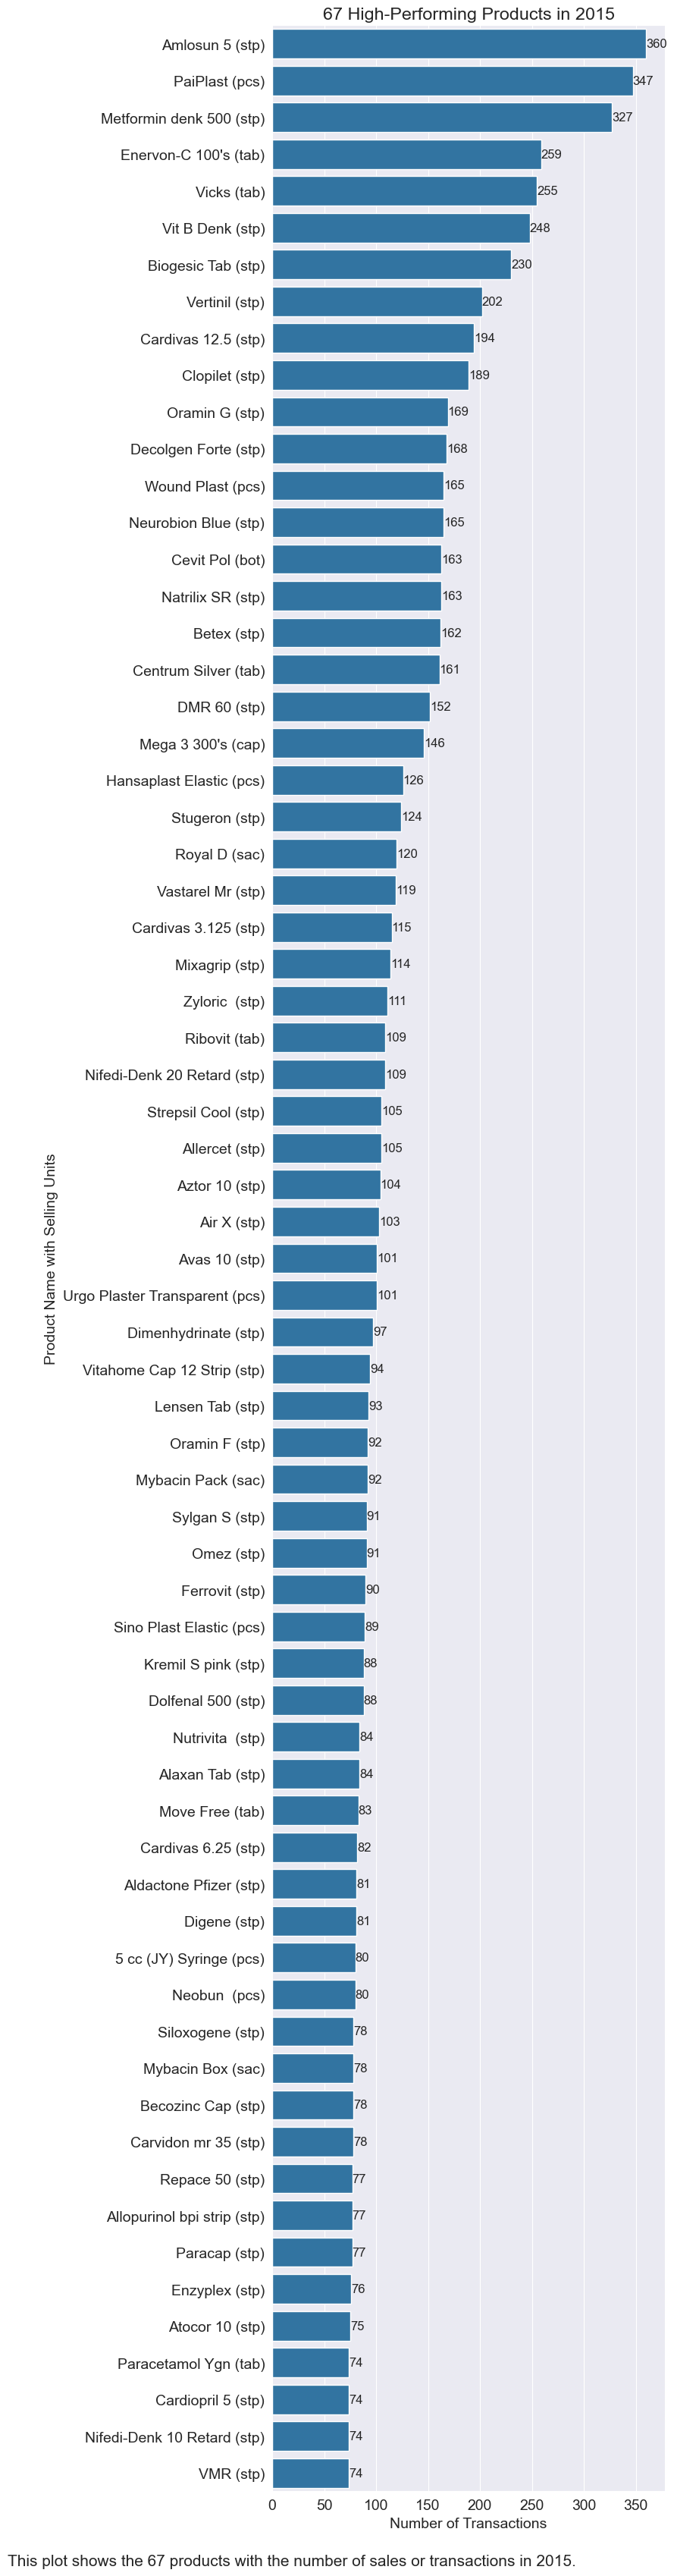

In [128]:
high_performing_df = high_performing_df.sort_values('InvoiceCount', ascending=False)

plt.figure(figsize=(9,34))
ax=sns.barplot(x='InvoiceCount',y='ProductName',data=high_performing_df)

# Add text annotations for each bar
for idx, value in enumerate(high_performing_df['InvoiceCount']):
    ax.text(value, idx, str(value), ha='left', va='center',fontsize=12)
    
labels = [f"{product} ({unit})" for product, unit in zip(high_performing_df.ProductName, high_performing_df.Unit)]

# Customize y-tick labels
plt.yticks(ticks=range(len(high_performing_df)), labels=labels)

plt.xlabel('Number of Transactions')
plt.ylabel('Product Name with Selling Units')
plt.title('67 High-Performing Products in 2015')
plt.annotate('This plot shows the 67 products with the number of sales or transactions in 2015.',
             xy=(0.05, -0.03), xycoords='axes fraction',
             ha='center', fontsize=15)
plt.tight_layout();
# plt.figtext(0.4, -0.1, "This plot shows the 15 products with the highest number of sales or transactions.", wrap=True, horizontalalignment='center', fontsize=12);

#### Identifying the First Quantile of Lowest-Performing Products
There are many factors to consider when deciding whether to keep products in the store, such as trends and product types. However, since every product has an expiration date, it is essential to analyze the products with low sales frequency. 

In [129]:
lowest_performing_df = agg_explore_df[agg_explore_df['InvoiceCount'] < q1].reset_index()

In [130]:
lowest_performing_df.shape

(188, 5)

In [131]:
lowest_count_df = (
    lowest_performing_df
        .groupby('InvoiceCount')
        .agg({'ProductName':'count'})
        .sort_values(by='InvoiceCount')
        .reset_index()
)

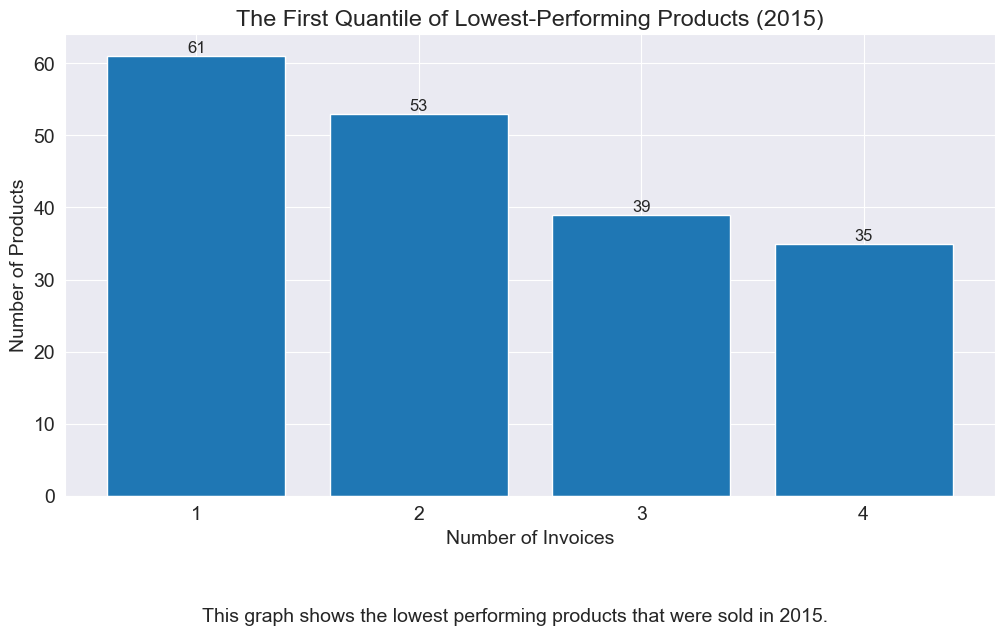

In [132]:
plt.figure(figsize=(12, 6))
plt.bar(x=lowest_count_df.InvoiceCount, height='ProductName',data=lowest_count_df)

for idx, value in enumerate(lowest_count_df["ProductName"]):
    plt.text(lowest_count_df["InvoiceCount"].iloc[idx], 
             value, str(value), ha="center", va="bottom", fontsize=12)
    
plt.xticks(ticks=lowest_count_df["InvoiceCount"], labels=lowest_count_df["InvoiceCount"].astype(int))
   
plt.title('The First Quantile of Lowest-Performing Products (2015)')
plt.xlabel('Number of Invoices')
plt.ylabel('Number of Products')
plt.figtext(0.5, -0.1, "This graph shows the lowest performing products that were sold in 2015.", wrap=True, horizontalalignment='center', fontsize=14);

>Notably, 188 products were sold four times or fewer. These low-performing products should be analyzed further for trends, usage, product types, or chemical composition to decide whether they should remain in the store.<br>


## Summary
In 2015:<br>
- A total of 873 products were sold.
- No clear monthly pattern was observed in sales transactions.
- Both the average number of transactions and the average quantity sold showed a downward trend.
- Customer purchase sizes remained consistent throughout the year.
- The top-selling products appeared as outliers in the box plot, indicating significantly higher sales compared to the rest.

**Next Step**:
- Ensure top-selling products are consistently in stock to meet demand.
- The lowest-selling products should be further analyzed for patterns in trends, usage, product categories, or chemical composition to determine whether improvements can be made or if discontinuation is appropriate.
- Implement strategies to boost overall sales performance.
